# Напоминание из теории

В случае оптимального байесовского классификатора разделяющая поверхность будет задаваться уравнением

$$
\mathbb{P}(C_1|x) = \mathbb{P}(C_2|x) \Longleftrightarrow \mathbb{P}(x|C_1)\mathbb{P}(C_1) = \mathbb{P}(x|C_2)\mathbb{P}(C_2).
$$

Теперь обсудим пример построения порождающей модели. Естественно, на основе нормального распределения или гауссианов. Пусть

$$
\mathbb{P}(x|C_i) = \mathbb{N}(x|\mu_i, \Sigma_i).
$$

Разделяющая поверхность будет иметь вид

$$
\ln \mathbb{P}(C_1) - \frac{1}{2}\ln |\Sigma_1| - \frac{1}{2}(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1) = \ln \mathbb{P}(C_2) - \frac{1}{2}\ln |\Sigma_2| - \frac{1}{2}(x-\mu_2)^{T}\Sigma_2^{-1}(x-\mu_2).
$$

Понятно, что разделяющая поверхность квадратичная. Для оценки параметров $\mu_i$ и $\Sigma_i$ имеет смысл использовать соответствующие выборочные характеристики (выборочное среднее и выборочная ковариационная матрица). Оценить $\mathbb{P}(C_i)$ можно долей числа элементов соответствующего класса.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score

import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

In [3]:
#гауссовский наивный байесовский классификатор

In [4]:
df = pd.read_csv(r'C:\Users\david\Desktop\мага\Статистика и машинное обучение\LR5\LR5\penguins_binary_classification.csv')

In [6]:
#преобразую целевую переменную
df['species'] = df['species'].replace({'Adelie': 0, 'Gentoo': 1})
df = pd.get_dummies(df, columns=['island'],drop_first=True)
df.drop(columns=['year'], inplace=True)


In [7]:
df

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen
0,0,39.1,18.7,181.0,3750.0,0,1
1,0,39.5,17.4,186.0,3800.0,0,1
2,0,40.3,18.0,195.0,3250.0,0,1
3,0,36.7,19.3,193.0,3450.0,0,1
4,0,39.3,20.6,190.0,3650.0,0,1
...,...,...,...,...,...,...,...
269,1,47.2,13.7,214.0,4925.0,0,0
270,1,46.8,14.3,215.0,4850.0,0,0
271,1,50.4,15.7,222.0,5750.0,0,0
272,1,45.2,14.8,212.0,5200.0,0,0


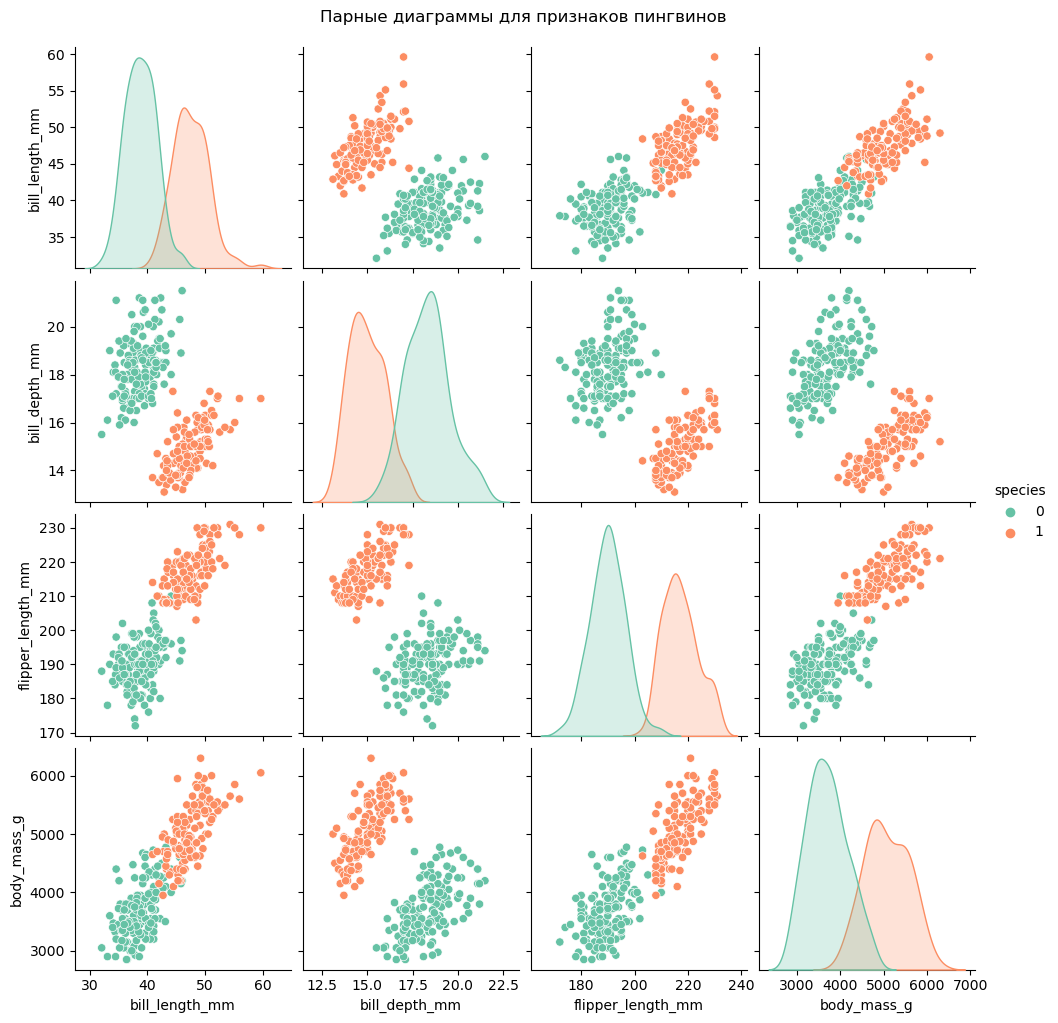

In [9]:
# парная диаграмма 
sns.pairplot(df.drop(columns=['island_Dream', 'island_Torgersen']), hue='species', diag_kind='kde', palette='Set2')
plt.suptitle('Парные диаграммы для признаков пингвинов', y=1.02)
plt.show()

In [46]:
X = np.array(df.iloc[:, 1:])
y = np.array(df.iloc[:, 0])

In [37]:
#фукнция, разделяющая признаки по классам для оценки параметров 
def separate_by_class(X, y):
    separated = {}
    for i in range(len(X)):
        class_label = y[i]
        if class_label not in separated:
            separated[class_label] = []
        separated[class_label].append(X[i])
    return separated

#функция для оценки параметрво
def calculate_stat(X):
    X = np.array(X)
    mean = np.mean(X, axis=0)
    deviations = X - mean
    covariance_matrix = np.dot(deviations.T, deviations) / len(X)
    return mean, covariance_matrix

In [78]:
#вычисляем для двух классов статистику: среднее , cov bи априорнуб вероятность
def train_bayesian_classifier(X, y):
    separated = separate_by_class(X, y)
    statistics = {}
    total_count = len(y)
    class_priors = {}

    for class_label, instances in separated.items():
        means, covariance_matrix = calculate_stat(instances)
        statistics[class_label] = {
            'means': means,
            'covariance': covariance_matrix
        }
        #априорная вероятность
        class_priors[class_label] = len(instances) / total_count
    
    return statistics, class_priors
    
    

In [79]:
#плотность вероятности многомерного нормального распределения
#определяю вероятность для нового обькта
def calculate_multivariate_gaussian(x, mean, covariance_matrix):
    d = len(mean)
    det = np.linalg.det(covariance_matrix)  # определеитель cov для нормализции распределния
    inv = np.linalg.inv(covariance_matrix)  # Обратная матрица
    deviation = x - mean
    # считаю vaхаланобисово расстояние показывает расстояние от точки x до центра с учето формы распределения
    exponent = np.exp(-0.5 * np.dot(np.dot(deviation.T, inv), deviation))
    #коэф нормализации (чтобы интеграл вероятности по всем знач = 1) умножаем на коэф значения экспоненты чтобы получить P(X|C)
    return (1 / np.sqrt((2 * np.pi) ** d * det)) * exponent

In [80]:
#вычисляю вероятность для каждого класса
def calculate_class_probabilities_with_covariance(input_vector, statistics, class_priors):
    probabilities = {}
    for class_label, params in statistics.items():
        mean = params['means']
        covariance = params['covariance']
        probabilities[class_label] = class_priors[class_label]  # P(C_i)
        probabilities[class_label] *= calculate_multivariate_gaussian(input_vector, mean, covariance)
    return probabilities

In [81]:
def predict_with_covariance(statistics, class_priors, input_vector):
    probabilities = calculate_class_probabilities_with_covariance(input_vector, statistics, class_priors)
    return max(probabilities, key=probabilities.get)

In [82]:
#оубчение модели вычисление основных статситик
statistics, class_priors = train_bayesian_classifier(X, y)

# LDA 

Линейный дискриминантный анализ - алгоритм классификации и понижения размерности. Основная идея LDA заключается в предположении о многомерном нормальном распределении признаков внутри классов и поиске их линейного преобразования, которое максимизирует межклассовую дисперсию и минимизирует внутриклассовую.

Другими словами, объекты разных классов должны иметь нормальное распределение и располагаться как можно дальше друг от друга, а одного класса — как можно ближе.

Основные предположения метода:

Распределение признаков в каждом классе нормально (гауссово).

Ковариационные матрицы классов одинаковы (
Σ
1
=
Σ
2
Σ 
1
​
 =Σ 
2
​
 ). (ковариационные матрицы классов становятся равными, что приводит к линейной разделяющей поверхности (гиперплоскости))
 
Признаки независимы внутри каждого класса

В рамках предположения, что $\Sigma_1 = \Sigma_2$ и

$$
\Sigma =  \frac{|C_1|}{|C_1| + |C_2|}\Sigma_1 + \frac{|C_2|}{|C_1| + |C_2|}\Sigma_2,
$$

где

$$
\Sigma_i = \frac{1}{|C_i|}\sum_{x\in C_i}\left(x-\mu_i\right)\left(x-\mu_i\right)^T
$$

разделяющая поверхность будет иметь вид гиперплоскости

$$
\left(\mu_2 - \mu_1\right)\Sigma^{-1}x + \frac{1}{2} \left(\mu_1^{T}\Sigma^{-1}\mu_1 - \mu_2^{T}\Sigma^{-1}\mu_2\right) + \ln \frac{\mathbb{P}(C_2)}{\mathbb{P}(C_1)} = 0.
$$

### Генерация данных

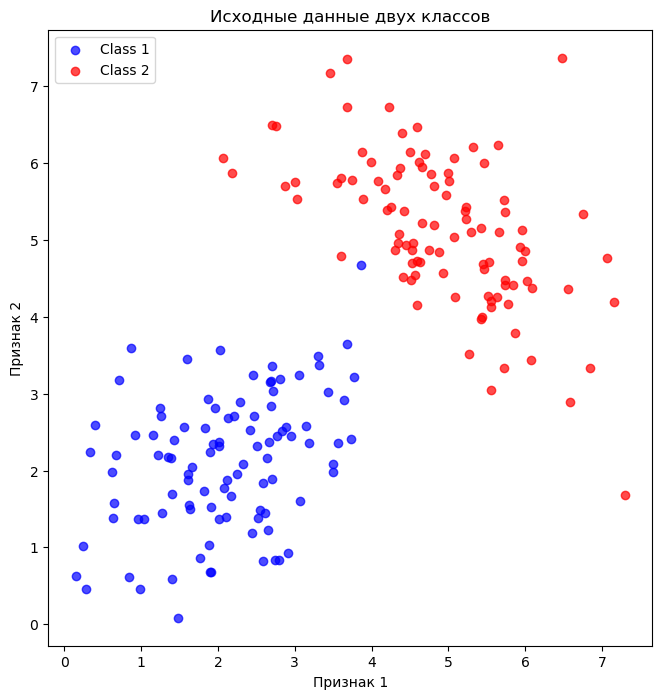

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Генерация данных
np.random.seed(42)

class_1_size = 100
class_2_size = 100

class_1 = np.random.multivariate_normal(mean=[2, 2], cov=[[1, 0.5], [0.5, 1]], size=class_1_size)
class_2 = np.random.multivariate_normal(mean=[5, 5], cov=[[1, -0.5], [-0.5, 1]], size=class_2_size)

# Объединение данных
X = np.vstack((class_1, class_2))
y = np.hstack((np.zeros(100), np.ones(100)))

# Визуализация данных
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.legend()
plt.title('Исходные данные двух классов')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

## Вычисление параметров модели

In [3]:
# Оценка среднего

def get_mu(class_objects):
    '''
      Параметры
  ----------
  class_objects : {array-like} формы (n_samples, n_features)
      Объекты одного класса, где `n_samples` — число объектов
      и `n_features` — число признаков.

  Что возвращается
  -------
  mu : вектор из координат центроида класса
    '''

    means = np.mean(class_objects, axis = 0)
    return means


mu_1 = get_mu(class_1)
mu_2 = get_mu(class_2)

assert np.isclose(mu_1, np.array([2.08307042, 2.11709274])).all() and np.isclose(mu_2, np.array([4.91067717, 5.13281048])).all()

In [106]:
class_1_mu = class_1-mu_1


In [110]:
np.dot(class_1_mu.T, class_1_mu)/len(class_1_mu)

array([[0.8150929 , 0.29751939],
       [0.29751939, 0.76768711]])

In [109]:
np.cov(class_1, rowvar=False, bias=True)

array([[0.8150929 , 0.29751939],
       [0.29751939, 0.76768711]])

In [4]:
#метод предполагает, что ковариационные матрицы классов одинаковы
#таким образом общая cov считается как взвешенная сумма cov
#далее считаем обратную матрицу ковариации
#

def get_Sigma_inv(class_1, class_2, mu_1, mu_2):
    """
    Параметры
    ----------
    class_1 : {array-like} формы (n_samples, n_features)
      Объекты класса 1, где `n_samples` — число объектов
      и `n_features` — число признаков.
    class_2 : {array-like} формы (n_samples, n_features)
      Объекты класса 2, где `n_samples` — число объектов
      и `n_features` — число признаков.
    mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
    mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2

    Что возвращается
    -------
    Sigma_inv : обращенная общая матрица ковариаций
    """
    #кол-во обьектов в каждом классе
    n1 = class_1.shape[0]
    n2 = class_2.shape[0]
    
    deviation_1 = class_1 - mu_1
    deviation_2 = class_2 - mu_2
    
    cov_1  = np.dot(deviation_1.T, deviation_1)/len(deviation_1)
    cov_2  = np.dot(deviation_2.T, deviation_2)/len(deviation_2)
    
    #считаю взвешенную cov
    Sigma = (n1 / (n1 + n2))  * cov_1 + (n2 / (n1 + n2)) * cov_2
    
    #обратная cov
    Sigma_inv = np.linalg.inv(Sigma)
    
    return Sigma_inv

Sigma_inv = get_Sigma_inv(class_1, class_2, mu_1, mu_2)

assert np.isclose(Sigma_inv, np.array([[1.0782101, 0.18128796], [0.18128796, 1.19546925 ]])).all()

In [5]:
# Нормальный вектор гиперплоскости - вектор, перпендикулярный разделяющей 
#гиперпоскости. Данный вектор задает направление в котором гиперплоскоссть ориентированная
#
#указывает направление наибольшего разлчиия между двумя классами соединяя центроиды с учетом масштаба и корреляции признаков
#задача u1-u2 указать направление вдоль которого нужно разместить гиперплоскость для лучшего разделения классов
#
def get_w(mu_1, mu_2, Sigma_inv):
    """
    Параметры
    ----------
    mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
    mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2
    Sigma_inv : {numpy.ndarray} — обращенная общая матрица ковариаций

    Что возвращается
    -------
    w : нормальный вектор гиперплоскости
    """
    #наивное направление между центроидами
    delta_mu = mu_2 - mu_1
    #корректирует направление учитывая масштаю признаков и их корреляцию
    #указывает направление, вдоль которого классы максимально различимы
    w = np.dot(Sigma_inv, delta_mu)
    return w

w = get_w(mu_1, mu_2, Sigma_inv)

assert np.isclose(w, np.array([3.59546745, 4.11780887])).all()

54.999507606299645

In [12]:
# Коэффициент смещения гиперплоскости
#указывает где именно гиперплоскость пересекает нормальный вектор w 

def get_b(mu_1, mu_2, Sigma_inv, class_1_size, class_2_size):
    """
    Параметры
    ----------
    mu_1 : {numpy.ndarray} — вектор из координат центроида класса 1
    mu_2 : {numpy.ndarray} — вектор из координат центроида класса 2
    Sigma_inv : {numpy.ndarray} — обращенная общая матрица ковариаций
    class_1_size : {int} — количество элементов класса 1
    class_2_size : {int} — количество элементов класса 2

    Что возвращается
    -------
    b : коэффициент смещения гиперплоскости
    """
    w = np.dot(Sigma_inv, (mu_2 - mu_1))
    
    #расчет априорные вероятности
    P_C1 = class_1_size / (class_1_size + class_2_size)
    P_C2 = class_2_size / (class_1_size + class_2_size)
    
    
    b = -0.5 * np.dot(w, (mu_1 + mu_2)) + np.log(P_C1 / P_C2)
    
    return b


b = get_b(mu_1, mu_2, Sigma_inv, class_1_size, class_2_size)

assert np.isclose(b, -27.499753803149826)

array([0.14727542, 0.2194729 , 0.29167038, 0.36386786, 0.43606534,
       0.50826282, 0.5804603 , 0.65265778, 0.72485526, 0.79705274,
       0.86925023, 0.94144771, 1.01364519, 1.08584267, 1.15804015,
       1.23023763, 1.30243511, 1.37463259, 1.44683007, 1.51902755,
       1.59122504, 1.66342252, 1.73562   , 1.80781748, 1.88001496,
       1.95221244, 2.02440992, 2.0966074 , 2.16880488, 2.24100236,
       2.31319985, 2.38539733, 2.45759481, 2.52979229, 2.60198977,
       2.67418725, 2.74638473, 2.81858221, 2.89077969, 2.96297717,
       3.03517466, 3.10737214, 3.17956962, 3.2517671 , 3.32396458,
       3.39616206, 3.46835954, 3.54055702, 3.6127545 , 3.68495199,
       3.75714947, 3.82934695, 3.90154443, 3.97374191, 4.04593939,
       4.11813687, 4.19033435, 4.26253183, 4.33472931, 4.4069268 ,
       4.47912428, 4.55132176, 4.62351924, 4.69571672, 4.7679142 ,
       4.84011168, 4.91230916, 4.98450664, 5.05670412, 5.12890161,
       5.20109909, 5.27329657, 5.34549405, 5.41769153, 5.48988

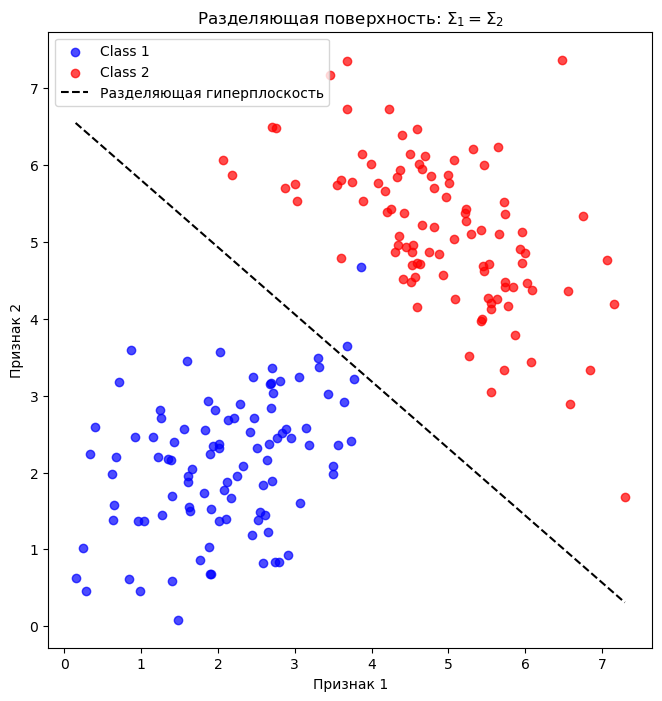

In [18]:
# Построение разделяющей прямой
x_vals = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)


# Координаты y для гиперплоскости
y_vals = -(w[0] / w[1]) * x_vals - b / w[1]

# Визуализация
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.7)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.7)
plt.plot(x_vals, y_vals, label='Разделяющая гиперплоскость', color='black', linestyle = "--")
plt.legend()
plt.title('Разделяющая поверхность: $\Sigma_1 = \Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()

Если к данным добавить фиктивный столбец из единиц и в начало вектора весов добавить коэффициент, отвечающий за смещение, то классификатор будет выглядеть следующим образом

In [21]:
X_stacked = np.hstack((np.array([1]*len(X)).reshape(-1,1), X))
W_stacked = np.hstack((b,w))

def predict(sample, W):
    result = sample @ W
    if result < 0:
        return 1
    return 2

In [25]:
# Тестовый объект 1
sample_1 = np.array([1,3,2])
# Предсказание класса
predict(sample_1, W_stacked)

1

In [26]:
# Тестовый объект 2
sample_2 = np.array([1,6,5])
# Предсказание класса
predict(sample_2, W_stacked)

2

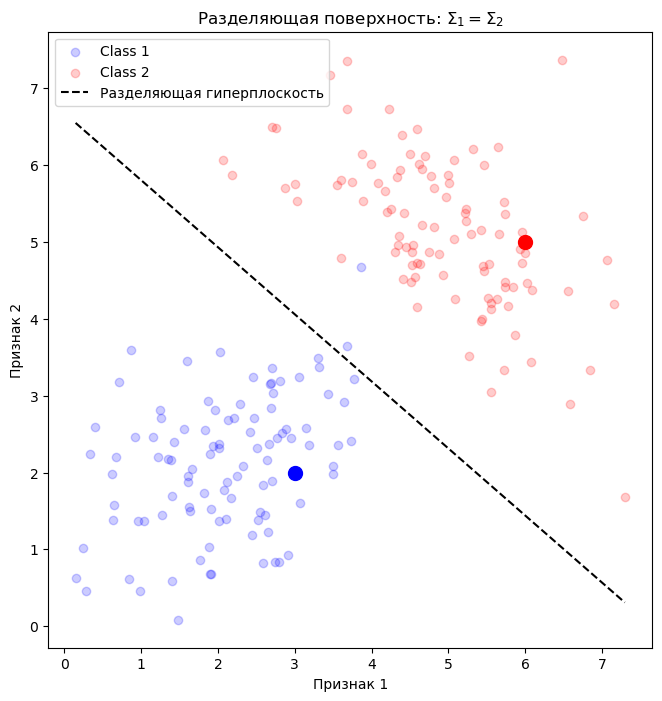

In [27]:
# Визуализация
plt.figure(figsize=(8,8))
plt.scatter(class_1[:, 0], class_1[:, 1], label='Class 1', c='blue', alpha=0.2)
plt.scatter(class_2[:, 0], class_2[:, 1], label='Class 2', c='red', alpha=0.2)
plt.scatter(sample_1[1], sample_1[2], s=100, c='blue')
plt.scatter(sample_2[1], sample_2[2], s=100, c='red')
plt.plot(x_vals, y_vals, label='Разделяющая гиперплоскость', color='black', linestyle = "--")
plt.legend()
plt.title('Разделяющая поверхность: $\Sigma_1 = \Sigma_2$')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.axis('scaled')
plt.show()